# Work related to the simulations
This messy notebook contains the code to find all available realizations. The extraction is done outside in `extract_cmip6.py`. Then the PCA+KKZ selection is done here.

Here again, paths have been removed. `datadir` is where all data is saved. 

In [1]:
import intake
import json
import pandas as pd
from pathlib import Path
import geopandas as gpd

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from clisops.core.subset import subset_gridpoint
import numpy as np
import xarray as xr
import xclim as xc
from xclim import ensembles as xce

import matplotlib.pyplot as plt
import matplotlib as mpl
xc.set_options(cf_compliance='log')
# pd.set_option('display.max_rows', None)
dask.config.set(**{'array.slicing.split_large_chunks': False})

2022-01-31 12:42:51,633 - xclim - INFO - Matplotlib installed. Setting make_graph to True.


# Création du catalogue

In [12]:
catalog = intake.open_esm_datastore("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json")
catalog

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [13]:
#catalog = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
catalog.df['memb_name'] = catalog.df.apply(lambda row: f"{row.institution_id}_{row.source_id}_{row.member_id}", axis=1)
catalog.df['ds_name'] = catalog.df.apply(lambda row: f"{row.institution_id}_{row.source_id}_{row.experiment_id}", axis=1)

In [14]:
comptes = {}
catalogues = {}
grids = ['gn', 'gr', 'gr1', 'gr2']
for ssp in ['historical', 'ssp245', 'ssp370', 'ssp585']:
    query_o = dict(
        variable_id=['tasmax', 'tasmin', 'pr'],
        grid_label=grids,
        table_id='day',
        experiment_id=ssp
    )
    catsub = catalog.search(**query_o)

    names = {}
    for g in grids:
        cs = catsub.search(grid_label=g)
        ns = cs.df.groupby('memb_name').count().variable_id
        names[g] = set(ns[ns >= 3].index)

    for i, g in enumerate(grids[1:], 1):
        for better_g in grids[:i]:
            names[g] = names[g] - names[better_g]

    queries = [{'grid_label': g, 'memb_name': names[g]} for g in grids]
    cat = pd.concat([catsub.search(**query).df for query in queries])
    cat = intake.open_esm_datastore({'esmcat': catsub.esmcat, 'df': cat})
    catalogues[ssp] = cat

In [15]:
catalogues['historical']

,unique
activity_id,1
institution_id,22
source_id,36
experiment_id,1
member_id,156
table_id,1
variable_id,3
grid_label,3
zstore,1221
dcpp_init_year,0


In [16]:
names = {ssp: set(catalogues[ssp].df.memb_name.unique()) for ssp in catalogues.keys()}

common585 = names['historical'].intersection(names['ssp245']).intersection(names['ssp585'])
cat = pd.concat([catalogues[ssp].search(memb_name=common585).df for ssp in set(catalogues.keys()) - {'ssp370', 'ssp245+370'}])
cat245585= intake.open_esm_datastore({'df': cat, 'esmcat': catalog.esmcat})

In [17]:
c = cat245585.nunique()
print('SSPs 2 4.5 and 5 8.5:', c.loc['source_id'], 'models and', c.loc['ds_name'], 'realizations')

SSPs 2 4.5 and 5 8.5: 26 models and 78 realizations


In [14]:
catalogues['ssp245+370'].df.to_csv('cat_245_370.csv')
catalogues['ssp245+585'].df.to_csv('cat_245_585.csv')
with open('esmcol_data.json', 'w') as f:
    json.dump(catalog.esmcol_data, f)

# Traitement des simulations récalcitrantes

EC-Earth a été extrait avec `extract_ec-earth.py`, copie du script `extract_cmip6.py` mais avec des contournements pour quelques simulations qui gossent.

Ici on fusionne les membres.

In [38]:
ref = xr.open_dataset('/datadir/simulations/raw/EC-Earth-Consortium_EC-Earth3/r131i1p1f1_historical.nc')

In [39]:
dss = {}
for ssp in ['ssp245', 'ssp370', 'ssp585']:
    dss[ssp] = xr.open_mfdataset(f'/datadir/simulations/raw/EC-Earth-Consortium_EC-Earth3/*_{ssp}.nc')

In [42]:
hists = [xr.open_dataset(p).sel(time=slice('1970', '2014')).reindex(time=ref.time, method='ffill')
         for p in Path('/datadir/simulations/raw/EC-Earth-Consortium_EC-Earth3/').glob('*_historical.nc')]
dss['historical'] = xr.concat(hists, 'member_id')

In [51]:
for ssp in ['ssp245', 'ssp370', 'ssp585']:
    ds = xr.concat([dss['historical'], dss[ssp]], 'time')
    ds = ds.chunk({'member_id': 1, 'time': -1})
    ds.to_zarr(f'/datadir/simulations/raw/EC-Earth-Consortium_EC-Earth3_{ssp}.zarr')

# Choix des simulations

On veut 1 réalisation par paire de modèle/institution.

PCA sur les indices + KKZ récursif

In [2]:
root = Path('/datadir/simulations/raw_ind/')
def construct_ensemble(ssp):
    reals = []
    for p in root.glob(f'*_{ssp}.zarr'):
        print(p.stem)
        ds = xr.open_zarr(p).sel(time=slice('1991', None))
        if ds.member_id.size == 0:
            print('woups')
            continue
        deltas = ds.sel(time=slice('2071', '2100')).mean('time') - ds.sel(time=slice('1991', '2020')).mean('time')
        crit = deltas.mean('site')
        mod = p.stem[5:-7]
        crit['member_id'] = [f"{mod}_{mid.item()}" for mid in crit.member_id]
        crit = crit.rename(member_id='realization')
        reals.append(crit)
    return xr.concat(reals, 'realization')

In [3]:
with ProgressBar():
    ssp245 = construct_ensemble('ssp245')
    ssp245.to_netcdf('/datadir/simulations/criteria_ssp245_all.nc')

year_CNRM-CERFACS_CNRM-ESM2-1_ssp245
year_EC-Earth-Consortium_EC-Earth3-Veg-LR_ssp245
year_INM_INM-CM4-8_ssp245
year_NIMS-KMA_KACE-1-0-G_ssp245
year_CAS_FGOALS-g3_ssp245
year_BCC_BCC-CSM2-MR_ssp245
year_NCC_NorESM2-LM_ssp245
year_NUIST_NESM3_ssp245
year_CNRM-CERFACS_CNRM-CM6-1_ssp245
year_INM_INM-CM5-0_ssp245
year_CMCC_CMCC-ESM2_ssp245
year_MIROC_MIROC-ES2L_ssp245
year_AS-RCEC_TaiESM1_ssp245
year_CCCma_CanESM5_ssp245
year_NOAA-GFDL_GFDL-CM4_ssp245
year_MPI-M_MPI-ESM1-2-LR_ssp245
year_CSIRO_ACCESS-ESM1-5_ssp245
year_IPSL_IPSL-CM6A-LR_ssp245
year_MIROC_MIROC6_ssp245
year_NCC_NorESM2-MM_ssp245
year_CSIRO-ARCCSS_ACCESS-CM2_ssp245
year_EC-Earth-Consortium_EC-Earth3-CC_ssp245
year_NOAA-GFDL_GFDL-ESM4_ssp245
year_KIOST_KIOST-ESM_ssp245
year_MRI_MRI-ESM2-0_ssp245
year_EC-Earth-Consortium_EC-Earth3-Veg_ssp245
year_EC-Earth-Consortium_EC-Earth3_ssp245
[######################                  ] | 56% Completed | 37.8s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###########################             ] | 68% Completed | 45.7s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  5.2s
[######################                  ] | 56% Completed | 37.5s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###########################             ] | 68% Completed | 45.8s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  4.9s
[###                                     ] | 8% Completed |  6.8s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#####                                   ] | 13% Completed | 10.3s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  1min  6.5s
[##############                          ] | 36% Completed | 25.0s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[##################                      ] | 46% Completed | 31.9s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  6.8s
[########################################] | 100% Completed |  1min  4.3s
[######################                  ] | 56% Completed | 36.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###########################             ] | 68% Completed | 43.9s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  1.8s
[##                                      ] | 6% Completed |  5.2s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###                                     ] | 8% Completed |  6.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 59.3s
[##################                      ] | 45% Completed | 28.5s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[#######################                 ] | 57% Completed | 36.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  0.5s
[########################################] | 100% Completed | 59.5s
[######################                  ] | 56% Completed | 32.2s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###########################             ] | 68% Completed | 39.2s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 56.6s
[##                                      ] | 6% Completed |  6.4s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###                                     ] | 8% Completed |  7.3s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 58.5s
[##############                          ] | 36% Completed | 22.6s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[##################                      ] | 46% Completed | 28.7s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 58.2s
[########################################] | 100% Completed |  1min  1.0s
[######################                  ] | 56% Completed | 34.3s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###########################             ] | 69% Completed | 41.6s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 58.6s
[###                                     ] | 8% Completed |  7.6s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#####                                   ] | 13% Completed | 10.7s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 58.5s
[##################                      ] | 45% Completed | 27.3s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[#######################                 ] | 57% Completed | 34.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed |  1min  0.0s
[#################                       ] | 44% Completed | 29.5s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[#######################                 ] | 57% Completed | 36.7s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 59.6s
[###                                     ] | 8% Completed |  7.4s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#####                                   ] | 14% Completed | 11.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 57.4s
[#################                       ] | 44% Completed | 27.9s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[#######################                 ] | 57% Completed | 35.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 58.0s
[########################################] | 100% Completed |  1min  1.7s
[#################                       ] | 44% Completed | 28.2s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[#######################                 ] | 57% Completed | 35.4s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 57.9s
[##                                      ] | 6% Completed |  6.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###                                     ] | 8% Completed |  7.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 57.1s
[##############                          ] | 36% Completed | 22.4s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[##################                      ] | 46% Completed | 28.2s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed |  1min  4.0s
[######################                  ] | 56% Completed | 35.4s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###########################             ] | 68% Completed | 42.2s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 59.0s
[##                                      ] | 6% Completed |  6.7s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[###                                     ] | 8% Completed |  7.5s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 58.4s
[##################                      ] | 45% Completed | 28.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[#######################                 ] | 57% Completed | 35.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 59.0s
[########################################] | 100% Completed | 14min 55.3s


In [ ]:
with ProgressBar():
    ssp585 = construct_ensemble('ssp585')
    ssp585.to_netcdf('/datadir/simulations/criteria_ssp585_all.nc')

year_CNRM-CERFACS_CNRM-ESM2-1_ssp585
year_EC-Earth-Consortium_EC-Earth3-Veg-LR_ssp585
year_INM_INM-CM4-8_ssp585
year_NIMS-KMA_KACE-1-0-G_ssp585
year_CAS_FGOALS-g3_ssp585
year_BCC_BCC-CSM2-MR_ssp585
year_NCC_NorESM2-LM_ssp585
year_NUIST_NESM3_ssp585
year_CNRM-CERFACS_CNRM-CM6-1_ssp585
year_INM_INM-CM5-0_ssp585
year_CMCC_CMCC-ESM2_ssp585
year_MIROC_MIROC-ES2L_ssp585
year_AS-RCEC_TaiESM1_ssp585
year_CCCma_CanESM5_ssp585
year_NOAA-GFDL_GFDL-CM4_ssp585
year_MPI-M_MPI-ESM1-2-LR_ssp585


Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f104b286940>
Traceback (most recent call last):
  File "/exec/pbourg/.conda/analog/lib/python3.9/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


year_IPSL_IPSL-CM6A-LR_ssp585
year_MIROC_MIROC6_ssp585
year_NCC_NorESM2-MM_ssp585
year_EC-Earth-Consortium_EC-Earth3-CC_ssp585
year_NOAA-GFDL_GFDL-ESM4_ssp585
year_KIOST_KIOST-ESM_ssp585
year_MRI_MRI-ESM2-0_ssp585
year_EC-Earth-Consortium_EC-Earth3-Veg_ssp585
year_EC-Earth-Consortium_EC-Earth3_ssp585
year_CSIRO-ARCCSS_ACCESS-CM2_ssp585
[#################################       ] | 82% Completed | 49.5s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


[#################################       ] | 84% Completed | 50.1s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[##################################      ] | 87% Completed | 51.8s

/exec/pbourg/.conda/analog/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[####################################### ] | 99% Completed | 58.4s

Force : KIOST_KIOST-ESM_r1i1p1f1

In [2]:
ssp245 = xr.open_dataset('/datadir/simulations/criteria_ssp245_all.nc', decode_timedelta=False)
ssp585 = xr.open_dataset('/datadir/simulations/criteria_ssp585_all.nc', decode_timedelta=False)
for name, var in ssp245.data_vars.items():
    if var.attrs.get('units') == 'nanoseconds':
        ssp245[name] = xc.core.units.convert_units_to(var, 'days')
        ssp585[name] = xc.core.units.convert_units_to(var, 'days')

crit245 = ssp245.to_array('criteria')
crit245['criteria'] = [f"{critname}_ssp245" for critname in crit245.criteria.values]
crit585 = ssp585.to_array('criteria')
crit585['criteria'] = [f"{critname}_ssp585" for critname in crit585.criteria.values]
crit = xr.concat([crit245, crit585], 'criteria')
crit = crit.where(crit.isnull().sum('criteria') == 0, drop=True)
crit

<xarray.DataArray (criteria: 40, realization: 157)>
array([[344.05444336, 106.9879837 ,  69.52327728, ...,  84.0165863 ,
        158.42466736, 139.43598938],
       [  2.64055127,  21.85376253,  12.3357297 , ...,  14.71323077,
         11.23016199, 100.4343116 ],
       [-12.06512821, -33.3574359 , -19.83025641, ..., -27.58871795,
        -29.97025641, -28.27230769],
       ...,
       [ 63.81589744,  13.82461538,   9.31897436, ...,  12.36307692,
         12.54      ,  11.31487179],
       [ 36.02564103,   8.69384615,   5.64871795, ...,   2.84769231,
          0.95230769,   0.86615385],
       [ 14.53658009,   5.81563854,   3.23115325, ...,   4.25769949,
          6.15206337,   5.68580675]])
Coordinates:
  * realization  (realization) object 'AS-RCEC_TaiESM1_r1i1p1f1' ... 'NUIST_N...
  * criteria     (criteria) <U13 'CDD_ssp245' 'FAF_ssp245' ... 'TXx_ssp585'

In [6]:
from eofs.xarray import Eof

In [7]:
def color_legend(reals):
    mods = list(set([splitmod(real.item())[0] for real in reals]))
    N = len(mods)
    cmap = {mod: plt.cm.gist_rainbow(i / (N - 1)) for i, mod in enumerate(mods)}
    colors = [cmap[splitmod(real.item())[0]] for real in reals]
    handles = [mpl.lines.Line2D([0], [0], marker='o', color=cmap[mod], label=mod) for mod in mods]
    return colors, handles

def splitmod(name):
    return '_'.join(name.split('_')[:-1]), name.split('_')[-1]

In [8]:
data = crit.rename(realization='time').transpose('time', 'criteria')
# standardize (réduction + centrage)
data = (data - data.mean('time')) / data.std('time')
# remove outlier
data = data.drop_sel(time=['NUIST_NESM3_r2i1p1f1', 'AS-RCEC_TaiESM1_r1i1p1f1'])
solver = Eof(data)
solver

In [17]:
out = solver.pcs(npcs=3).rename(time='realization', mode='criteria')
varfrac = solver.varianceFraction()
print(varfrac[:10])
outscl = out * varfrac.rename(mode='criteria').isel(criteria=slice(None, 3))

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.75946235, 0.1220232 , 0.04389729, 0.02009911, 0.01133107,
       0.01023349, 0.00748138, 0.00487235, 0.00348767, 0.00320997])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions


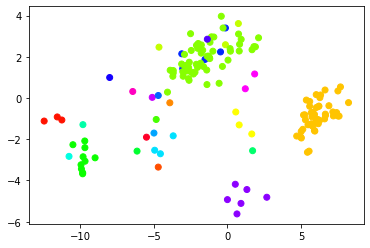

In [10]:
c, h = color_legend(out.realization)
plt.scatter(out.isel(criteria=0), -out.isel(criteria=1), c=c)

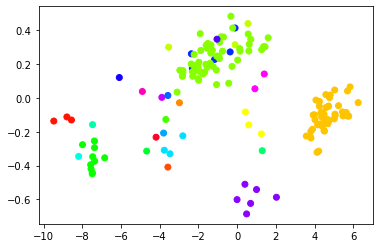

In [18]:
c, h = color_legend(outscl.realization)
plt.scatter(outscl.isel(criteria=0), -outscl.isel(criteria=1), c=c)

In [11]:
def recursive_kkz(da, repeat=True):
    model = xr.DataArray([splitmod(real.item())[0] for real in da.realization],
                         dims=('realization',),
                         coords={'realization': da.realization}
                        )
    expN = len(set(model.values))
    inds = xce.kkz_reduce_ensemble(da, da.realization.size)
    names = [da.realization.isel(realization=i).item() for i in inds]
    if repeat:
        while len(names) > expN:
            firsts = {}
            for name in names:
                mod = splitmod(name)[0]
                if mod not in firsts:
                    firsts[mod] = name
                else:
                    drop = (model == mod) & (da.realization != firsts[mod])
                    da = da.sel(realization=~drop)
                    break
            inds = xce.kkz_reduce_ensemble(da, da.realization.size)
            names = [da.realization.isel(realization=i).item() for i in inds]
    else:
        firsts = []
        mods = []
        for name in names:
            mod = splitmod(name)[0]
            if mod not in mods:
                mods.append(mod)
                firsts.append(name)
        names = firsts
    return names

In [19]:
names = recursive_kkz(out)
names

['MIROC_MIROC-ES2L_r1i1p1f2',
 'EC-Earth-Consortium_EC-Earth3-Veg-LR_r3i1p1f1',
 'CCCma_CanESM5_r13i1p1f1',
 'IPSL_IPSL-CM6A-LR_r14i1p1f1',
 'MRI_MRI-ESM2-0_r1i1p1f1',
 'MPI-M_MPI-ESM1-2-LR_r3i1p1f1',
 'CAS_FGOALS-g3_r4i1p1f1',
 'NOAA-GFDL_GFDL-CM4_r1i1p1f1',
 'MIROC_MIROC6_r1i1p1f1',
 'NIMS-KMA_KACE-1-0-G_r1i1p1f1',
 'NOAA-GFDL_GFDL-ESM4_r1i1p1f1',
 'CMCC_CMCC-ESM2_r1i1p1f1',
 'NUIST_NESM3_r1i1p1f1',
 'INM_INM-CM4-8_r1i1p1f1',
 'CSIRO-ARCCSS_ACCESS-CM2_r3i1p1f1',
 'NCC_NorESM2-LM_r1i1p1f1',
 'EC-Earth-Consortium_EC-Earth3_r125i1p1f1',
 'NCC_NorESM2-MM_r1i1p1f1',
 'INM_INM-CM5-0_r1i1p1f1',
 'BCC_BCC-CSM2-MR_r1i1p1f1',
 'CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2',
 'CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2',
 'EC-Earth-Consortium_EC-Earth3-Veg_r4i1p1f1',
 'EC-Earth-Consortium_EC-Earth3-CC_r1i1p1f1']

In [20]:
namescl = recursive_kkz(outscl)
namescl

['MIROC_MIROC-ES2L_r1i1p1f2',
 'EC-Earth-Consortium_EC-Earth3-Veg-LR_r3i1p1f1',
 'CCCma_CanESM5_r13i1p1f1',
 'IPSL_IPSL-CM6A-LR_r14i1p1f1',
 'MRI_MRI-ESM2-0_r1i1p1f1',
 'MPI-M_MPI-ESM1-2-LR_r3i1p1f1',
 'CAS_FGOALS-g3_r4i1p1f1',
 'NOAA-GFDL_GFDL-CM4_r1i1p1f1',
 'MIROC_MIROC6_r1i1p1f1',
 'NIMS-KMA_KACE-1-0-G_r1i1p1f1',
 'NOAA-GFDL_GFDL-ESM4_r1i1p1f1',
 'CMCC_CMCC-ESM2_r1i1p1f1',
 'NUIST_NESM3_r1i1p1f1',
 'INM_INM-CM4-8_r1i1p1f1',
 'CSIRO-ARCCSS_ACCESS-CM2_r3i1p1f1',
 'NCC_NorESM2-LM_r1i1p1f1',
 'EC-Earth-Consortium_EC-Earth3_r125i1p1f1',
 'NCC_NorESM2-MM_r1i1p1f1',
 'INM_INM-CM5-0_r1i1p1f1',
 'BCC_BCC-CSM2-MR_r1i1p1f1',
 'CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2',
 'CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2',
 'EC-Earth-Consortium_EC-Earth3-Veg_r4i1p1f1',
 'EC-Earth-Consortium_EC-Earth3-CC_r1i1p1f1']

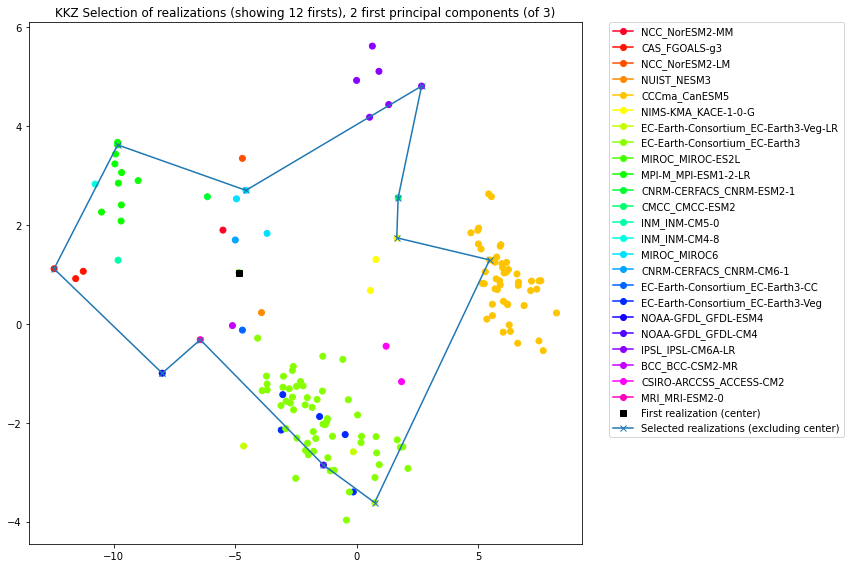

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
c, h = color_legend(out.realization)
ax.scatter(out.isel(criteria=0), out.isel(criteria=1), c=c)

sels = out.sel(realization=names[:12])
cent = sels.isel(realization=0)
pts = sels.isel(realization=slice(1, None))
vec = pts - cent
angle = np.arctan2(vec.isel(criteria=1), vec.isel(criteria=0))
pts = pts.sortby(angle)
pts = xr.concat([pts, pts.isel(realization=0)], 'realization')
ce, = ax.plot(cent.isel(criteria=0), cent.isel(criteria=1), 'ks', label='First realization (center)')
l, = ax.plot(pts.isel(criteria=0), pts.isel(criteria=1), marker='x', label='Selected realizations (excluding center)')

ax.legend(handles=h + [ce, l], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title('KKZ Selection of realizations (showing 12 firsts), 2 first principal components (of 3)')
fig.tight_layout()
fig.savefig('Figures/Selection_KKZ_2of3PC_12Real.png')